## Convert PRS prediction files into a new single unified format

In [95]:
import pandas as pd
import os 


In [96]:
hp_dicts={"pt3" : ["0.00000005", "0.0000001", "0.000001", "0.00001", "0.0001", "0.001", "0.005", "0.01", "0.05", "0.1", "0.2", "0.3", "0.4", "0.5"],
         "pt2" : ["0.00000005", "0.0000001", "0.000001", "0.00001", "0.0001", "0.001", "0.005", "0.01", "0.05", "0.1", "0.2", "0.3", "0.4", "0.5"],
         "ls" : [f'{a}-{b}' for a in [0.2, 0.5, 0.9, 1] for b in range(1, 21)],
         "ld" : [str(a) for a in range(1,103)]
         }
fields=["hp","beta","se","pval","prs.ngk.r2","null.ngk.r2","all.ngk.r2","prs.auroc","null.auroc","all.auroc","or.all","or.all.se","or.all.ci.min","or.all.ci.max","or.10","or.10.ci.min","or.10.ci.max","or.20","or.20.ci.min","or.20.ci.max","or.80","or.80.ci.min","or.80.ci.max","or.90","or.90.ci.min","or.90.ci.max","or.95","or.95.ci.min","or.95.ci.max","or.99","or.99.ci.min","or.99.ci.max"]

In [97]:
field_conversion={
    "threshold" : "hp",
    "or_all" : "or.all",
    "or_all_se" : "or.all.se",
    "or_all_ci_min" : "or.all.ci.min",
    "or_all_ci_max" : "or.all.ci.max",
    "or_80" : "or.80",
    "or_80_ci_min" : "or.80.ci.min",
    "or_80_ci_max" : "or.80.ci.max",
    "or_90" : "or.90",
    "or_90_ci_min" : "or.90.ci.min",
    "or_90_ci_max" : "or.90.ci.max",
    "or_95" : "or.95",
    "or_95_ci_min" : "or.95.ci.min",
    "or_95_ci_max" : "or.95.ci.max",
    "or_99" : "or.99",
    "or_99_ci_min" : "or.99.ci.min",
    "or_99_ci_max" : "or.99.ci.max",
    "all_ngkR2" : "all.ngk.r2",
    "prs_ngkR2" : "prs.ngk.r2",
    "null_ngkR2" : "null.ngk.r2",
    "roc_auc" : "prs.auroc",
    "P" : "pval",
    "BETA" : "beta",
    "SE" : "se"
}

In [106]:
target="ukbb_afr"
imp="impute2_1kg_eur"
method="ls"
n_reps=6
n_folds=5
base_rep=105


phenos=["ctrt", "chol", "hfvr", "hyty", "ht", "osar", "madd", "t2d", "utfi", "gerx", "angna", "ast"]
for pheno in phenos:
    discovery=f"UKB_{pheno}_eur"
    for cur_rep in range(1,n_reps+1):
        for cur_fold in range(1,n_folds+1):
            for set_type in ['validation']:
                prss_path=f"/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/{discovery}_{target}/{imp}/rep_{base_rep}_{cur_rep}/"
                df_agg=pd.DataFrame()
                for cur_hp in hp_dicts[method]:            
                        or_file_name=f"prs.cv.{method}_{pheno}__{cur_fold}_{n_folds}_{set_type}.or.summary.{cur_hp}.tsv"
                        summary_file_name=f"prs.cv.{method}_{pheno}__{cur_fold}_{n_folds}_{set_type}.statistics.{cur_hp}.tsv"
                        cur_or_file=os.path.join(prss_path,or_file_name)
                        cur_summary_file=os.path.join(prss_path,summary_file_name)
                        if os.path.exists(cur_or_file):
                            df_or=pd.read_csv(cur_or_file, sep='\t')
                            df_stats=pd.read_csv(cur_summary_file, sep='\t').iloc[[-1]]
                            df_merged=pd.merge(df_or, df_stats, on=['threshold'])
                            df_merged.rename(columns=field_conversion, inplace=True)
                            df_agg=pd.concat((df_agg,df_merged))
                df_agg=df_agg.reindex(columns=fields).dropna(1)
                new_summary_file_name=f"prs.cv.{method}_{pheno}__{cur_fold}_{n_folds}_{set_type}.statistics.tsv"
                cur_new_summary_file=os.path.join(prss_path,new_summary_file_name)
                df_agg.to_csv(cur_new_summary_file, sep='\t', index=None)
                print(cur_new_summary_file)
#                 display(df_agg)

    for cur_rep in range(1,n_reps+1):     
        for set_type in ['test']:
            prss_path=f"/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/{discovery}_{target}/{imp}/rep_{base_rep}_{cur_rep}/"
            df_agg=pd.DataFrame()
            for cur_hp in hp_dicts[method]:
                or_file_name=f"prs.cv.{method}_{pheno}__{n_folds}_{set_type}.or.summary.{cur_hp}.tsv"
                summary_file_name=f"prs.cv.{method}_{pheno}__{n_folds}_{set_type}.statistics.{cur_hp}.tsv"
                cur_or_file=os.path.join(prss_path,or_file_name)
                cur_summary_file=os.path.join(prss_path,summary_file_name)
    #             print(cur_or_file)
                if os.path.exists(cur_or_file):
                    df_or=pd.read_csv(cur_or_file, sep='\t')
                    df_stats=pd.read_csv(cur_summary_file, sep='\t').iloc[[-1]]
                    df_merged=pd.merge(df_or, df_stats, on=['threshold'])
                    df_merged.rename(columns=field_conversion, inplace=True)
                    df_agg=pd.concat((df_agg,df_merged))
            df_agg=df_agg.reindex(columns=fields).dropna(1)
            new_summary_file_name=f"prs.cv.{method}_{pheno}__{n_folds}_{set_type}.statistics.tsv"
            cur_new_summary_file=os.path.join(prss_path,new_summary_file_name)
            df_agg.to_csv(cur_new_summary_file, sep='\t', index=None)
            print(cur_new_summary_file)
#             display(df_agg)                                      

/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ctrt_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_ctrt__1_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ctrt_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_ctrt__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ctrt_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_ctrt__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ctrt_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_ctrt__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ctrt_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_ctrt__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ctrt_eur_ukbb_afr/impute2_1kg_eur/rep_105_2/prs.cv.ls_ctrt__1_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ctrt_eur_ukbb_afr/impute2_1kg_eur/rep_105_2/prs.cv.ls_ctrt__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga

/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_chol_eur_ukbb_afr/impute2_1kg_eur/rep_105_5/prs.cv.ls_chol__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_chol_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_chol__1_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_chol_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_chol__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_chol_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_chol__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_chol_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_chol__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_chol_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_chol__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_chol_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_chol__5_test.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_

/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_hyty_eur_ukbb_afr/impute2_1kg_eur/rep_105_3/prs.cv.ls_hyty__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_hyty_eur_ukbb_afr/impute2_1kg_eur/rep_105_3/prs.cv.ls_hyty__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_hyty_eur_ukbb_afr/impute2_1kg_eur/rep_105_3/prs.cv.ls_hyty__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_hyty_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_hyty__1_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_hyty_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_hyty__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_hyty_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_hyty__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_hyty_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_hyty__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga

/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_osar_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_osar__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_osar_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_osar__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_osar_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_osar__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_osar_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_osar__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_osar_eur_ukbb_afr/impute2_1kg_eur/rep_105_2/prs.cv.ls_osar__1_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_osar_eur_ukbb_afr/impute2_1kg_eur/rep_105_2/prs.cv.ls_osar__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_osar_eur_ukbb_afr/impute2_1kg_eur/rep_105_2/prs.cv.ls_osar__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga

/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_madd_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_madd__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_madd_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_madd__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_madd_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_madd__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_madd_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_madd__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_madd_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_madd__5_test.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_madd_eur_ukbb_afr/impute2_1kg_eur/rep_105_2/prs.cv.ls_madd__5_test.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_madd_eur_ukbb_afr/impute2_1kg_eur/rep_105_3/prs.cv.ls_madd__5_test.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_ma

/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_utfi_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_utfi__1_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_utfi_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_utfi__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_utfi_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_utfi__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_utfi_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_utfi__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_utfi_eur_ukbb_afr/impute2_1kg_eur/rep_105_6/prs.cv.ls_utfi__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_utfi_eur_ukbb_afr/impute2_1kg_eur/rep_105_1/prs.cv.ls_utfi__5_test.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_utfi_eur_ukbb_afr/impute2_1kg_eur/rep_105_2/prs.cv.ls_utfi__5_test.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRS

/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_angna_eur_ukbb_afr/impute2_1kg_eur/rep_105_3/prs.cv.ls_angna__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_angna_eur_ukbb_afr/impute2_1kg_eur/rep_105_3/prs.cv.ls_angna__5_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_angna_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_angna__1_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_angna_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_angna__2_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_angna_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_angna__3_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_angna_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_angna__4_5_validation.statistics.tsv
/specific/netapp5/gaga/gaga-pd/prs_data/PRSs/UKB_angna_eur_ukbb_afr/impute2_1kg_eur/rep_105_4/prs.cv.ls_angna__5_5_validation.statistics.tsv
/specific/net

=== PRS method: P+T (EUR LD), Target set: UKB SAS ===


,Trait,n=100,n=500,or_diff
0,angna,1.20,1.15,-0.06
1,ast,1.26,1.33,0.07
2,chol,1.25,1.26,0.02
3,ctrt,1.22,1.13,-0.08
4,gerx,1.11,1.08,-0.03
5,hfvr,1.26,1.21,-0.05
6,ht,1.40,1.41,0.01
7,hyty,1.48,1.50,0.02
8,madd,1.09,1.03,-0.06
9,osar,1.19,1.11,-0.09


=== PRS method: P+T (target-set LD), Target set: UKB SAS ===


,Trait,n=100,n=500,or_diff
0,angna,1.09,1.06,-0.03
1,ast,1.30,1.31,0.00
2,chol,1.25,1.25,0.01
3,ctrt,1.21,1.12,-0.09
4,gerx,1.07,1.02,-0.04
5,hfvr,1.27,1.17,-0.10
6,ht,1.45,1.49,0.04
7,hyty,1.54,1.51,-0.03
8,madd,1.00,1.04,0.04
9,osar,1.02,1.06,0.04


=== PRS method: Lassosum, Target set: UKB SAS ===


,Trait,n=100,n=500,or_diff
0,angna,1.18,1.17,-0.01
1,ast,1.36,1.35,-0.01
2,chol,1.37,1.36,-0.01
3,ctrt,1.10,1.09,-0.01
4,gerx,1.13,1.12,-0.01
5,hfvr,1.40,1.37,-0.03
6,ht,1.58,1.56,-0.01
7,hyty,1.47,1.44,-0.03
8,madd,1.11,1.11,-0.00
9,osar,1.06,1.02,-0.04


=== PRS method: P+T (EUR LD), Target set: UKB AFR ===


,Trait,n=100,n=500,or_diff
0,angna,1.32,1.21,-0.11
1,ast,1.13,1.08,-0.04
2,chol,1.28,1.26,-0.02
3,ctrt,1.10,1.00,-0.10
4,gerx,1.08,1.12,0.03
5,hfvr,1.19,1.13,-0.05
6,ht,1.21,1.23,0.01
7,hyty,1.13,1.13,-0.00
8,madd,1.12,1.09,-0.03
9,osar,1.00,1.09,0.09


=== PRS method: P+T (target-set LD), Target set: UKB AFR ===


,Trait,n=100,n=500,or_diff
0,angna,1.29,1.13,-0.17
1,ast,1.11,1.10,-0.01
2,chol,1.20,1.22,0.02
3,ctrt,1.05,0.97,-0.08
4,gerx,1.13,1.02,-0.11
5,hfvr,1.17,1.22,0.05
6,ht,1.26,1.26,-0.00
7,hyty,1.28,1.25,-0.03
8,madd,1.13,1.08,-0.05
9,osar,1.21,1.28,0.07


=== PRS method: Lassosum, Target set: UKB AFR ===


,Trait,n=100,n=500,or_diff
0,angna,1.37,1.29,-0.08
1,ast,1.17,1.13,-0.04
2,chol,1.25,1.23,-0.02
3,ctrt,1.03,0.97,-0.06
4,gerx,0.99,1.19,0.20
5,hfvr,1.21,1.25,0.04
6,ht,1.32,1.31,-0.01
7,hyty,1.23,1.24,0.01
8,madd,1.16,1.19,0.03
9,osar,1.17,1.17,0.00


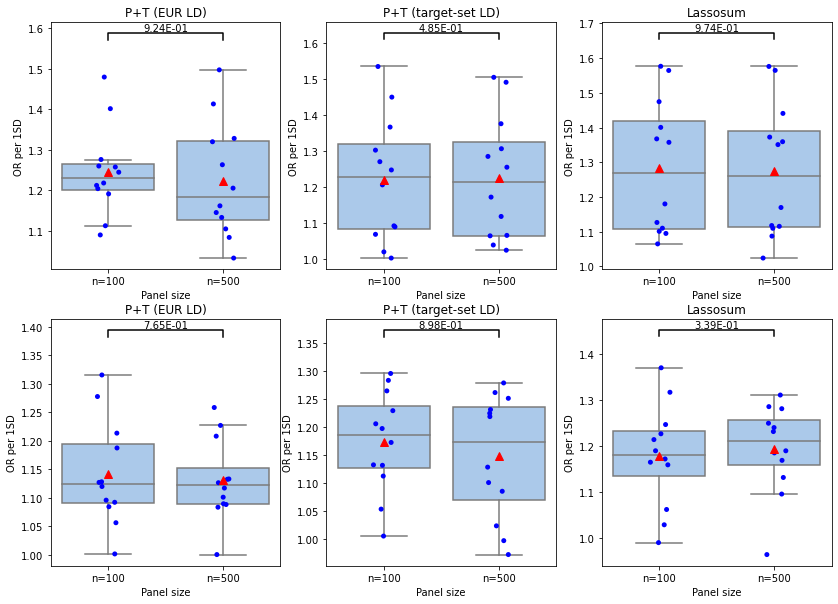

In [1]:
from scipy.stats import binom_test, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
method_names={'pt3': 'P+T (EUR LD)', 'pt2': 'P+T (target-set LD)', 'ls': 'Lassosum'}
target_names={'ukbb_afr': 'UKB AFR', 'ukbb_sas' : 'UKB SAS'}
methods=['pt3', 'pt2', 'ls']
targets=['ukbb_sas', 'ukbb_afr']
df_all=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_ukb_eur100_105_1_105_6.tsv', sep='\t')
df_all.index=df_all['prs_name']
fig, axs = plt.subplots(2,3, figsize=(14,10))
ind=0
for target in targets:
    for method in methods:
        df_method=df_all[(df_all['method']==method) & (df_all['prs_name'].apply(lambda a: target in a)) ] # 
        df_500=df_method.loc[df_method['imp']=='impute2_1kg_eur','or.all_mean_outer'].rename('n=500')
        df_100=df_method.loc[df_method['imp']=='impute2_1kg_eur100','or.all_mean_outer'].rename('n=100')
        df_cat=pd.concat((df_100,df_500),axis=1)
        df_cat['or_diff']=df_cat['n=500']-df_cat['n=100']
        trait_col=pd.Series(list(df_cat.index)).apply(lambda a: a.split('_')[1])
        df_cat.index=trait_col.index
        df_cat.insert(0,'Trait',trait_col)
        print(f'=== PRS method: {method_names[method]}, Target set: {target_names[target]} ===')
        display(round(df_cat,2))
#         print(f"pval={round(binom_test((df_cat['or_diff']>0).sum(), 3), (df_cat['or_diff']>0).count())}")
        pv=wilcoxon(df_cat['or_diff'], alternative='greater')[1]
        diff_mean=df_cat['or_diff'].mean()
        ax=axs[ind//3][ind%3]
#         ax.set_title(f"p-value={pv:.2E}") # mean OR difference={diff_mean:.2E}, 
        ax.set_title(f"{method_names[method]}")
        df_plot=pd.melt(df_cat, id_vars=['Trait'], value_vars=['n=100', 'n=500'])
        sns.boxplot(x='variable', y='value', data=df_plot, ax=ax, color=sns.color_palette('pastel')[0],  showfliers=False, showmeans=True, meanprops={"markersize":"8", "markerfacecolor": "red", "markeredgecolor": "red", "zorder": 10})
        sns.stripplot(x='variable', y='value', data=df_plot, ax=ax, color='blue')
        x1, x2 = 0, 1
        y_max=df_plot['value'].max()
        y, h, col = 1.05*y_max, y_max*0.01, 'k'
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        ax.text((x1+x2)*.5, y+h, f"{pv:.2E}", ha='center', va='bottom', color=col)
        ax.set_ylabel("OR per 1SD")
        ax.set_xlabel("Panel size")
#         ax.set_xticklabels(df_cat.columns[1:3])
        ind+=1



Index(['Trait', 'No imputation', 'European', 'South-Asian'], dtype='object')
Index(['Trait', 'No imputation', 'European', 'South-Asian'], dtype='object')
Index(['Trait', 'No imputation', 'European', 'South-Asian'], dtype='object')
Index(['Trait', 'No imputation', 'European', 'African'], dtype='object')
Index(['Trait', 'No imputation', 'European', 'African'], dtype='object')
Index(['Trait', 'No imputation', 'European', 'African'], dtype='object')


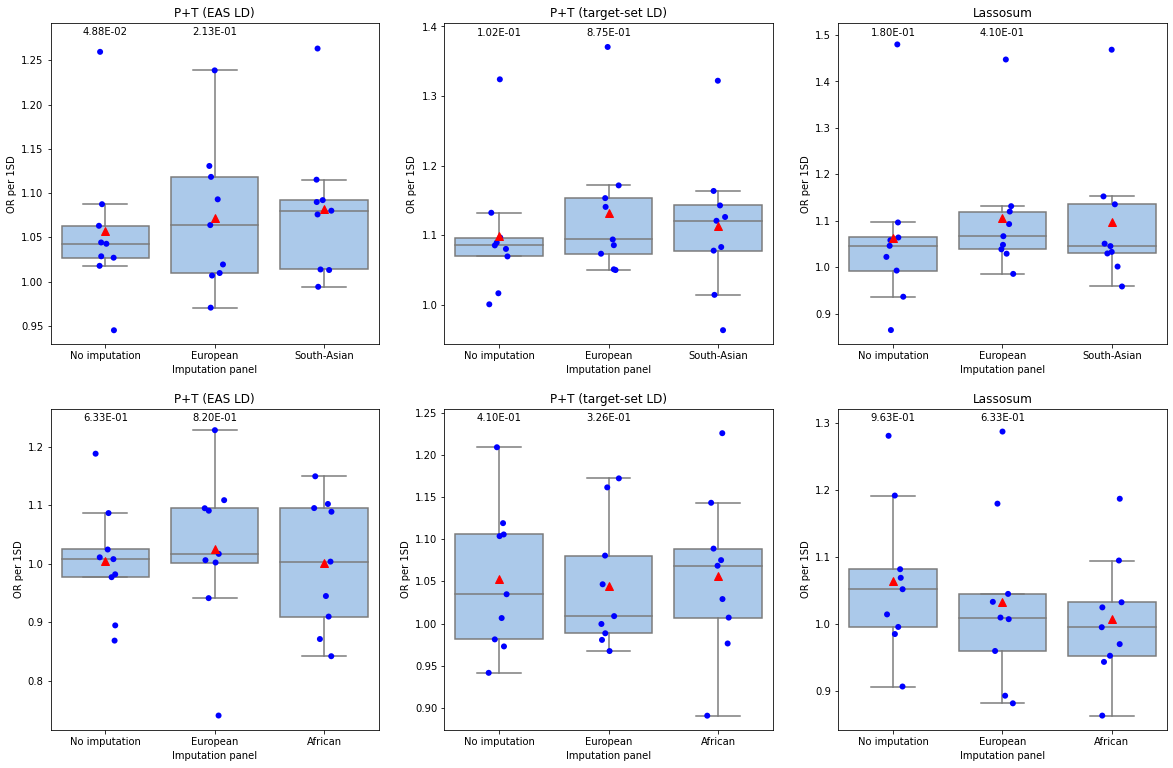

In [247]:
import os 
os.chdir('/specific/elkon/hagailevi/PRS/codebase')

from scipy.stats import binom_test, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from name_mappings import * 

method_names={'pt3': 'P+T (EAS LD)', 'pt2': 'P+T (target-set LD)', 'ls': 'Lassosum'}
target_names={'ukbb_afr': 'UKB AFR', 'ukbb_sas' : 'UKB SAS'}
methods=['pt3', 'pt2', 'ls']
targets=['ukbb_sas', 'ukbb_afr']
df_all=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_gc_eas_105_1_105_6.tsv', sep='\t')
df_all.index=df_all['prs_name']
fig, axs = plt.subplots(2,3, figsize=(20,13))
ind=0
for target in targets:
    for method in methods:
        df_method=df_all[(df_all['method']==method) & (df_all['prs_name'].apply(lambda a: target in a)) ] # 
        df_original=df_method.loc[df_method['imp']=='original','or.all_mean_outer'].rename(d_imp_names['original'])
        df_eur=df_method.loc[df_method['imp']=='impute2_1kg_eur','or.all_mean_outer'].rename(d_imp_names['impute2_1kg_eur'])
        df_target=df_method.loc[df_method['imp']==f'impute2_1kg_{target.split("_")[1]}','or.all_mean_outer'].rename(d_imp_names[f'impute2_1kg_{target.split("_")[1]}'])
        df_cat=pd.concat((df_original,df_eur, df_target),axis=1)
        trait_col=pd.Series(list(df_cat.index)).apply(lambda a: a.split('_')[1])
        df_cat.index=trait_col.index
        df_cat.insert(0,'Trait',trait_col)
#         print(f'=== PRS method: {method_names[method]}, Target set: {target_names[target]} ===')
#         display(round(df_cat,2))
# #         print(f"pval={round(binom_test((df_cat['or_diff']>0).sum(), 3), (df_cat['or_diff']>0).count())}")
        pv_original=wilcoxon(df_target-df_original, alternative='greater')[1]
        pv_eur=wilcoxon(df_target-df_eur, alternative='greater')[1]
#         diff_mean=df_cat['or_diff'].mean()
        ax=axs[ind//3][ind%3]
#         ax.set_title(f"p-value={pv:.2E}") # mean OR difference={diff_mean:.2E}, 
        ax.set_title(f"{method_names[method]}")
        print(df_cat.columns)
        df_plot=pd.melt(df_cat, id_vars=['Trait'], value_vars=df_cat.columns[1:])
        sns.boxplot(x='variable', y='value', data=df_plot, ax=ax, color=sns.color_palette('pastel')[0],  showfliers=False, showmeans=True, meanprops={"markersize":"8", "markerfacecolor": "red", "markeredgecolor": "red", "zorder": 10})
        sns.stripplot(x='variable', y='value', data=df_plot, ax=ax, color='blue', s=6)
        # x1, x2 = 0, 1
        y_max=df_plot['value'].max()
#         y, h, col = 1.05*y_max, y_max*0.01, 'k'
        # ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        ax.text(0, 1.01*y_max, f"{pv_original:.2E}", ha='center', va='bottom', color=col)
        ax.text(1, 1.01*y_max, f"{pv_eur:.2E}", ha='center', va='bottom', color=col)
        ax.set_ylabel("OR per 1SD")
        ax.set_xlabel("Imputation panel")
        ax.set_ylim(top=ax.get_ylim()[1]*1.01)
#         ax.set_xticklabels(df_cat.columns[1:3])
        ind+=1



In [200]:
import os 
os.chdir('/specific/elkon/hagailevi/PRS/codebase')

from scipy.stats import binom_test, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from name_mappings import * 

pm_symbol=u"\u00B1"

method_names={'pt3': 'P+T (EUR LD)', 'pt2': 'P+T (target-set LD)', 'ls': 'Lassosum'}
target_names={'ukbb_afr': 'UKB AFR', 'ukbb_sas' : 'UKB SAS'}
methods=['pt3', 'pt2', 'ls']
targets=['ukbb_sas', 'ukbb_afr']
df_all=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_public_eur_105_1_105_6.tsv', sep='\t')
df_all['target']=df_all['prs_name'].apply(lambda a: a.split('_')[-1])
mn=df_all.groupby(['target','method', 'imp'])['or.all_mean_outer'].mean()
std=df_all.groupby(['target','method', 'imp'])['or.all_mean_outer'].std()
df_agg=round(pd.concat((mn,std),axis=1),3)

df_agg['or.all']=df_agg.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
display(df_agg['or.all'].to_frame())

or.all
target method imp                         
afr    ls     impute2_1kg_afr    1.27±0.15
              impute2_1kg_eur  1.249±0.132
              original         1.263±0.117
       pt2    impute2_1kg_afr   1.25±0.192
              impute2_1kg_eur  1.197±0.121
              original         1.253±0.177
       pt3    impute2_1kg_afr  1.174±0.137
              impute2_1kg_eur    1.173±0.1
              original         1.184±0.097
sas    ls     impute2_1kg_eur  1.406±0.272
              impute2_1kg_sas   1.41±0.275
              original         1.379±0.258
       pt2    impute2_1kg_eur  1.378±0.219
              impute2_1kg_sas  1.399±0.283
              original         1.387±0.265
       pt3    impute2_1kg_eur  1.311±0.164
              impute2_1kg_sas  1.311±0.149
              original         1.269±0.145

In [200]:
import os 
os.chdir('/specific/elkon/hagailevi/PRS/codebase')

from scipy.stats import binom_test, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from name_mappings import * 

pm_symbol=u"\u00B1"

method_names={'pt3': 'P+T (EUR LD)', 'pt2': 'P+T (target-set LD)', 'ls': 'Lassosum'}
target_names={'ukbb_afr': 'UKB AFR', 'ukbb_sas' : 'UKB SAS'}
methods=['pt3', 'pt2', 'ls']
targets=['ukbb_sas', 'ukbb_afr']
df_all=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_public_eur_105_1_105_6.tsv', sep='\t')
df_all['target']=df_all['prs_name'].apply(lambda a: a.split('_')[-1])
mn=df_all.groupby(['method',  'imp'])['or.all_mean_outer'].mean()
std=df_all.groupby(['method', 'target', 'imp'])['or.all_mean_outer'].std()
df_agg=round(pd.concat((mn,std),axis=1),3)

df_agg['or.all']=df_agg.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
display(df_agg['or.all'].to_frame())

or.all
target method imp                         
afr    ls     impute2_1kg_afr    1.27±0.15
              impute2_1kg_eur  1.249±0.132
              original         1.263±0.117
       pt2    impute2_1kg_afr   1.25±0.192
              impute2_1kg_eur  1.197±0.121
              original         1.253±0.177
       pt3    impute2_1kg_afr  1.174±0.137
              impute2_1kg_eur    1.173±0.1
              original         1.184±0.097
sas    ls     impute2_1kg_eur  1.406±0.272
              impute2_1kg_sas   1.41±0.275
              original         1.379±0.258
       pt2    impute2_1kg_eur  1.378±0.219
              impute2_1kg_sas  1.399±0.283
              original         1.387±0.265
       pt3    impute2_1kg_eur  1.311±0.164
              impute2_1kg_sas  1.311±0.149
              original         1.269±0.145

In [226]:
import os 
os.chdir('/specific/elkon/hagailevi/PRS/codebase')

from scipy.stats import binom_test, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from name_mappings import * 

pm_symbol=u"\u00B1"

methods=['pt3', 'pt2', 'ls']
targets=['ukbb_sas', 'ukbb_afr']
df_afr=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_scz_eur_afr_105_1_105_6.tsv', sep='\t')
df_afr['target']=df_afr['prs_name'].apply(lambda a: a.split('_')[-1])
# display(df_afr)
mn=df_afr.groupby(['method',  'imp'])['or.all_mean_outer'].first()
std=df_afr.groupby(['method', 'imp'])['or.all_se_outer'].first()
df_agg_afr=round(pd.concat((mn,std),axis=1),3)
df_agg_afr['or.all']=df_agg_afr.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
df_agg_afr_col=df_agg_afr['or.all'].to_frame().rename(columns={"or.all":"gain_afr"})

df_aj=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_scz_eur_aj_105_1_105_6.tsv', sep='\t')
df_aj['target']=df_aj['prs_name'].apply(lambda a: a.split('_')[-1])
# display(df_afr)
mn=df_aj.groupby(['method',  'imp'])['or.all_mean_outer'].first()
std=df_aj.groupby(['method', 'imp'])['or.all_se_outer'].first()
df_agg_aj=round(pd.concat((mn,std),axis=1),3)
df_agg_aj['or.all']=df_agg_aj.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
df_agg_aj_col=df_agg_aj['or.all'].to_frame().rename(columns={"or.all":"dbg_scz19"})
df_agg_aj_col.index=[(a[0], a[1][:-1]) for a in df_agg_aj_col.index]
display(pd.concat((df_agg_afr_col, df_agg_aj_col), axis=1))

gain_afr    dbg_scz19
method imp                                      
ls     impute2_1kg_afr  1.595±0.126   2.51±0.086
       impute2_1kg_eas  1.501±0.163  2.471±0.089
       impute2_1kg_eur  1.457±0.119  2.501±0.072
pt2    impute2_1kg_afr  1.606±0.143  2.113±0.088
       impute2_1kg_eas  1.538±0.129   2.052±0.06
       impute2_1kg_eur  1.344±0.097  2.199±0.093
pt3    impute2_1kg_afr  1.279±0.048   2.087±0.06
       impute2_1kg_eas  1.457±0.108  2.057±0.086
       impute2_1kg_eur   1.49±0.114  2.066±0.074

In [248]:
import os 
os.chdir('/specific/elkon/hagailevi/PRS/codebase')

from scipy.stats import binom_test, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from name_mappings import * 

pm_symbol=u"\u00B1"

methods=['pt3', 'pt2', 'ls']
targets=['ukbb_sas', 'ukbb_afr']
df_eas=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_scz_eas_105_1_105_6.tsv', sep='\t')
df_eas['imp']=df_eas['imp'].apply(lambda a: a[:-1] if a[-1]=="2" else a)
df_eas['target']=df_eas['prs_name'].apply(lambda a: "gain_afr" if "gain_afr" in a else "dbg-scz19")

mn=df_eas.groupby(['target', 'method', 'imp'])['or.all_mean_outer'].first()
std=df_eas.groupby(['target', 'method', 'imp'])['or.all_se_outer'].first()
df_agg=round(pd.concat((mn,std),axis=1),3)
df_agg['or.all']=df_agg.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
display(df_agg)

# df_afr['target']=df_afr['prs_name'].apply(lambda a: a.split('_')[-1])
# # display(df_afr)
# mn=df_afr.groupby(['method',  'imp'])['or.all_mean_outer'].first()
# std=df_afr.groupby(['method', 'imp'])['or.all_se_outer'].first()
# df_agg_afr=round(pd.concat((mn,std),axis=1),3)
# df_agg_afr['or.all']=df_agg_afr.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
# df_agg_afr_col=df_agg_afr['or.all'].to_frame().rename(columns={"or.all":"gain_afr"})

# df_aj=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_scz_eur_aj_105_1_105_6.tsv', sep='\t')
# df_aj['target']=df_aj['prs_name'].apply(lambda a: a.split('_')[-1])
# # display(df_afr)
# mn=df_aj.groupby(['method',  'imp'])['or.all_mean_outer'].first()
# std=df_aj.groupby(['method', 'imp'])['or.all_se_outer'].first()
# df_agg_aj=round(pd.concat((mn,std),axis=1),3)
# df_agg_aj['or.all']=df_agg_aj.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
# df_agg_aj_col=df_agg_aj['or.all'].to_frame().rename(columns={"or.all":"dbg_scz19"})
# df_agg_aj_col.index=[(a[0], a[1][:-1]) for a in df_agg_aj_col.index]
# display(pd.concat((df_agg_afr_col, df_agg_aj_col), axis=1))

or.all_mean_outer  or.all_se_outer  \
target    method imp                                                   
dbg-scz19 ls     impute2_1kg_afr              1.043            0.049   
                 impute2_1kg_eas              1.122            0.048   
                 impute2_1kg_eur              1.074            0.044   
          pt2    impute2_1kg_afr              1.022            0.034   
                 impute2_1kg_eas              1.006            0.027   
                 impute2_1kg_eur              1.040            0.042   
          pt3    impute2_1kg_afr              0.949            0.026   
                 impute2_1kg_eas              0.950            0.028   
                 impute2_1kg_eur              0.922            0.053   
gain_afr  ls     impute2_1kg_afr              1.005            0.020   
                 impute2_1kg_eas              0.989            0.024   
                 impute2_1kg_eur              1.080            0.069   
          pt2    impute2_1kg_afr              1.019            0.039   
                 impute2_1kg_eas              1.041            0.051   
                 impute2_1kg_eur              1.075            0.058   
          pt3    impute2_1kg_afr              1.066            0.022   
                 impute2_1kg_eas              0.941            0.011   
                 impute2_1kg_eur              1.002            0.025   

                                       or.all  
target    method imp                           
dbg-scz19 ls     impute2_1kg_afr  1.043±0.049  
                 impute2_1kg_eas  1.122±0.048  
                 impute2_1kg_eur  1.074±0.044  
          pt2    impute2_1kg_afr  1.022±0.034  
                 impute2_1kg_eas  1.006±0.027  
                 impute2_1kg_eur   1.04±0.042  
          pt3    impute2_1kg_afr  0.949±0.026  
                 impute2_1kg_eas   0.95±0.028  
                 impute2_1kg_eur  0.922±0.053  
gain_afr  ls     impute2_1kg_afr   1.005±0.02  
                 impute2_1kg_eas  0.989±0.024  
                 impute2_1kg_eur   1.08±0.069  
          pt2    impute2_1kg_afr  1.019±0.039  
                 impute2_1kg_eas  1.041±0.051  
                 impute2_1kg_eur  1.075±0.058  
          pt3    impute2_1kg_afr  1.066±0.022  
                 impute2_1kg_eas  0.941±0.011  
                 impute2_1kg_eur  1.002±0.025

In [246]:
import os 
os.chdir('/specific/elkon/hagailevi/PRS/codebase')

from scipy.stats import binom_test, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from name_mappings import * 

pm_symbol=u"\u00B1"

methods=['pt3', 'pt2', 'ls']
targets=['ukbb_sas', 'ukbb_afr']
df_eas=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_scz_eur_105_1_105_6.tsv', sep='\t')
df_eas['imp']=df_eas['imp'].apply(lambda a: a[:-1] if a[-1]=="2" else a)
df_eas['target']=df_eas['prs_name'].apply(lambda a: "gain_afr" if "gain_afr" in a else "dbg-scz19")

mn=df_eas.groupby(['target', 'method', 'imp'])['or.all_mean_outer'].first()
std=df_eas.groupby(['target', 'method', 'imp'])['or.all_se_outer'].first()
df_agg=round(pd.concat((mn,std),axis=1),3)
df_agg['or.all']=df_agg.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
display(df_agg)

# df_afr['target']=df_afr['prs_name'].apply(lambda a: a.split('_')[-1])
# # display(df_afr)
# mn=df_afr.groupby(['method',  'imp'])['or.all_mean_outer'].first()
# std=df_afr.groupby(['method', 'imp'])['or.all_se_outer'].first()
# df_agg_afr=round(pd.concat((mn,std),axis=1),3)
# df_agg_afr['or.all']=df_agg_afr.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
# df_agg_afr_col=df_agg_afr['or.all'].to_frame().rename(columns={"or.all":"gain_afr"})

# df_aj=pd.read_csv('/specific/netapp5/gaga/gaga-pd/prs_data/output/prs.cv.choose_params_scz_eur_aj_105_1_105_6.tsv', sep='\t')
# df_aj['target']=df_aj['prs_name'].apply(lambda a: a.split('_')[-1])
# # display(df_afr)
# mn=df_aj.groupby(['method',  'imp'])['or.all_mean_outer'].first()
# std=df_aj.groupby(['method', 'imp'])['or.all_se_outer'].first()
# df_agg_aj=round(pd.concat((mn,std),axis=1),3)
# df_agg_aj['or.all']=df_agg_aj.apply(lambda a: f'{a.iloc[0]}{pm_symbol}{a.iloc[1]}',axis=1)
# df_agg_aj_col=df_agg_aj['or.all'].to_frame().rename(columns={"or.all":"dbg_scz19"})
# df_agg_aj_col.index=[(a[0], a[1][:-1]) for a in df_agg_aj_col.index]
# display(pd.concat((df_agg_afr_col, df_agg_aj_col), axis=1))

or.all_mean_outer  or.all_se_outer  \
target    method imp                                                   
dbg-scz19 ls     impute2_1kg_afr              2.510            0.086   
                 impute2_1kg_eas              2.471            0.089   
                 impute2_1kg_eur              2.501            0.072   
          pt2    impute2_1kg_afr              2.113            0.088   
                 impute2_1kg_eas              2.052            0.060   
                 impute2_1kg_eur              2.199            0.093   
          pt3    impute2_1kg_afr              2.087            0.060   
                 impute2_1kg_eas              2.057            0.086   
                 impute2_1kg_eur              2.066            0.074   
gain_afr  ls     impute2_1kg_afr              1.595            0.126   
                 impute2_1kg_eas              1.501            0.163   
                 impute2_1kg_eur              1.457            0.119   
          pt2    impute2_1kg_afr              1.606            0.143   
                 impute2_1kg_eas              1.538            0.129   
                 impute2_1kg_eur              1.344            0.097   
          pt3    impute2_1kg_afr              1.279            0.048   
                 impute2_1kg_eas              1.457            0.108   
                 impute2_1kg_eur              1.490            0.114   

                                       or.all  
target    method imp                           
dbg-scz19 ls     impute2_1kg_afr   2.51±0.086  
                 impute2_1kg_eas  2.471±0.089  
                 impute2_1kg_eur  2.501±0.072  
          pt2    impute2_1kg_afr  2.113±0.088  
                 impute2_1kg_eas   2.052±0.06  
                 impute2_1kg_eur  2.199±0.093  
          pt3    impute2_1kg_afr   2.087±0.06  
                 impute2_1kg_eas  2.057±0.086  
                 impute2_1kg_eur  2.066±0.074  
gain_afr  ls     impute2_1kg_afr  1.595±0.126  
                 impute2_1kg_eas  1.501±0.163  
                 impute2_1kg_eur  1.457±0.119  
          pt2    impute2_1kg_afr  1.606±0.143  
                 impute2_1kg_eas  1.538±0.129  
                 impute2_1kg_eur  1.344±0.097  
          pt3    impute2_1kg_afr  1.279±0.048  
                 impute2_1kg_eas  1.457±0.108  
                 impute2_1kg_eur   1.49±0.114